In [1]:
import flowpm

the mininal working example, let's check it still works with and without short range

In [2]:
%pylab inline
from flowpm import linear_field, lpt_init, nbody, cic_paint
import tensorflow as tf
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

klin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[1]

ipklin = iuspline(klin, plin)

Populating the interactive namespace from numpy and matplotlib


In [29]:
stages = np.linspace(0.1, 1.0, 10, endpoint=True)
initial_conditions = flowpm.linear_field(16,#32,          # size of the cube
                                         100,         # Physical size of the cube
                                         ipklin,      # Initial powerspectrum
                                         batch_size=1,seed=1)
initial_conditions32 = flowpm.linear_field(32,          # size of the cube
                                         100,         # Physical size of the cube
                                         ipklin,      # Initial powerspectrum
                                         batch_size=1,seed=1)

# Sample particles
state = flowpm.lpt_init(initial_conditions, a0=0.1)   
state32 = flowpm.lpt_init(initial_conditions32, a0=0.1)   


# # Evolve particles down to z=0
final_state = flowpm.nbody(state, stages, 16,short_range=False)         
final_state32 = flowpm.nbody(state32, stages, 32,short_range=False)         


# # Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
final_field32 = flowpm.cic_paint(tf.zeros_like(initial_conditions32), final_state32[0])

with tf.Session() as sess:
    state_l = sess.run(final_state)
    sim_l = sess.run(final_field)
    state_l32 = sess.run(final_state32)
    sim_l32 = sess.run(final_field32)


dbug max LR force is 0.030417932
dbug max LR force is 0.030417932
dbug max LR force is 0.030417932
dbug max LR force is 0.030417932
dbug max LR force is 0.030417932
dbug max LR force is 0.030417932
dbug max LR force is 0.030417932
dbug max LR force is 0.030417932
dbug max LR force is 0.030417932
dbug max LR force is 0.030417932
dbug max LR force is 0.10166875
dbug max LR force is 0.10166875
dbug max LR force is 0.10166875
dbug max LR force is 0.10166875
dbug max LR force is 0.10166875
dbug max LR force is 0.10166875
dbug max LR force is 0.10166875
dbug max LR force is 0.10166875
dbug max LR force is 0.10166875
dbug max LR force is 0.10166875


In [41]:
#Try the short range
# Evolve particles down to z=0
final_state_s = flowpm.nbody(state, stages, 16,short_range=True,cm_scale=1,eps_s=.1,nsubcycles = 2,split=2)         

# Retrieve final density field
final_field_s = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state_s[0])

with tf.Session() as sess:
    state_s= sess.run(final_state_s)
    sim_s= sess.run(final_field_s)


dbug max LR force is 0.030417932
min x=15.26157283782959, max x=-0.18037278950214386
Post mod (what SR sees) min x=15.999876976013184, max x=0.0004794678243342787
global max eta for default timestep is 0.11, and for sr timestep is 0.11
global max zeta for default timestep is 0.00 and for sr timestep is 0.00
bin distr summary (for rough idea of load balance): min=0, max=7, mean=1.00, median=1.0, total/expected_total=1.0
dbug max SR force is 3.585674
in short range
substages [0.1  0.15 0.2 ]
subcycling: step=0 of 2
beginning - x_sr=0.100,p_sr=0.141,f_sr=0.100
min x=15.762150764465332, max x=-2.5336923599243164
Post mod (what SR sees) min x=15.99973201751709, max x=0.001485131331719458
global max eta for default timestep is 10.22, and for sr timestep is 5.11
global max zeta for default timestep is 0.09 and for sr timestep is 0.05
bin distr summary (for rough idea of load balance): min=0, max=7, mean=1.00, median=1.0, total/expected_total=1.0
dbug max SR force is 22.327366
end - x_sr=0.150

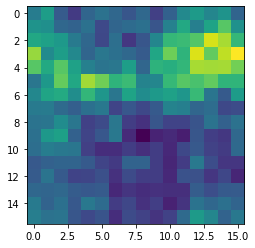

In [42]:
#visually comparing one-step fields
imshow(sim_s[0].sum(axis=0))
plt.show()




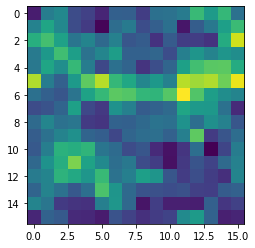

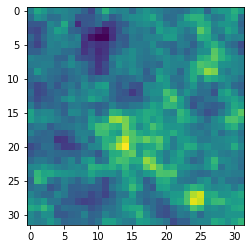

ValueError: operands could not be broadcast together with shapes (16,16,16) (32,32,32) 

In [21]:
imshow(sim_l[0].sum(axis=0))
plt.show()

imshow(sim_l32[0].sum(axis=0))
plt.show()

#L2 MSE
l2mse = np.sqrt(((sim_l[0]-sim_s[0])**2))
imshow(l2mse.sum(axis=0))
print(l2mse.max(),l2mse.min())
plt.show()

#pretty awful, looks like it just subtracting uniform background
#no it is slightly better than that, it looks more like  subtracting a diffused version of the long-range
#the diffusion is occuring because of the 2-body interaction time from high accelerations due to nearby particles
#because timestep is too short...

In [6]:
%%time
LL = []
for i in range(8**3):
    LL.append(5)
    

CPU times: user 67 µs, sys: 0 ns, total: 67 µs
Wall time: 70.8 µs


In [7]:
def speed_check():
    LL = []
    for i in range(8**3):
        LL.append(tf.constant([5]))
        
    return LL

In [8]:
%%time
with tf.Session() as sess:
    ll = sess.run(speed_check())
    

CPU times: user 1.11 s, sys: 27 ms, total: 1.13 s
Wall time: 1.14 s


In [ ]:
#calling tensorflow in the loops is a big problem...